In [16]:
import os
import os.path
import csv
import time
import PIL
import math
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from ImageNet import *
from CNN import *
from ResNet import *
from utils import *


In [17]:
# Initialize dataset related parameters
data_dir = './data'

workers = 1
batch_size = 64

######################## task 3.1 ##########################

max_epochs = 1
lr = 0.001

########################    END   ##########################


gpu = torch.cuda.is_available()
if gpu:
    print('Training on GPU')
else:
    print('Training on CPU')


Training on GPU


In [18]:
transform1 = transforms.RandomApply([
    ######################## task 0.1 ##########################
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(64, scale=(0.1, 1), ratio=(0.5, 2))
])
########################    END   ##########################

transform2 = transforms.ToTensor()

In [19]:
'加载数据'
dataset = TinyImageNetDataset(
    data_dir+'/train', transform=transforms.Compose([transform1, transform2]))
labels = dataset.get_labels()

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
idx_tr, idx_val = next(sss.split(labels, labels))

dataset_tr = torch.utils.data.Subset(dataset, idx_tr)
dataset_val = torch.utils.data.Subset(dataset, idx_val)

dataloader_tr = torch.utils.data.DataLoader(
    dataset_tr, batch_size=batch_size, shuffle=True, num_workers=workers)
dataloader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=batch_size, shuffle=True, num_workers=workers)

print('Training Dataset Length: ' + str(len(dataset_tr)))
print('Validation Dataset Length: ' + str(len(dataset_val)))

class_to_idx = dataset.get_class_to_idx()
dataset_test = TinyImageNetTestDataset(
    data_dir+'/val', annot_filename='val_annotations.txt', class_to_idx=class_to_idx, transform=transform2)
dataloader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=True, num_workers=workers)

print('Test Dataset Length: ' + str(len(dataset_test)))


Training Dataset Length: 90000
Validation Dataset Length: 10000
Test Dataset Length: 10000


In [20]:
# model = CNN()
model = ResNet()
model.apply(init_weights)
if gpu:
    model.cuda()

######################## task 3.2 ##########################
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
criterion = nn.CrossEntropyLoss()
########################    END   ##########################

model_filename = 'mymodel.pth'


In [21]:
print(model)
model.eval()
test_tensor = torch.randn(1, 3, 64, 64).cuda()
print(test_tensor.shape)
y1 = model(test_tensor)
print(y1.shape)


ResNet(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blk1): Sequential(
    (0): ResNetLayer(
      (conv0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skipconn_cnn): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
      (skipconn_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.15, inplace=False)
    )
    (1): ResNetLayer(
      (conv0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [22]:
def train(dataloader, model, optimizer, criterion):
    batch = 0
    loss = 0.0
    correct = 0.0

    model.train()

    with tqdm(total=len(dataloader.dataset), desc='train', leave=True, ncols=100, unit='B', unit_scale=True) as pbar:
        for X, Y in dataloader:
            if gpu:
                X = X.cuda()
                Y = Y.cuda()

            optimizer.zero_grad()
            logits = model(X)
            cur_loss = criterion(logits, Y)
            cur_loss.backward()
            optimizer.step()
            loss += cur_loss.item()
            pred = logits.argmax(dim=1)
            correct += pred.eq(Y).sum()

            pbar.update(dataloader.batch_size)

    loss = loss / float(len(dataloader.dataset))
    accuracy = float(correct) / float(len(dataloader.dataset)) * 100

    return loss, accuracy


In [23]:
def validate(dataloader, model, criterion):

    ######################## task 3.3 ##########################
    with torch.no_grad():
        batch = 0
        loss = 0.0
        correct = 0.0

        model.eval()

        with tqdm(total=len(dataloader.dataset), desc='validate', leave=True, ncols=100, unit='B', unit_scale=True) as pbar:
            for X, Y in dataloader:
                if gpu:
                    X = X.cuda()
                    Y = Y.cuda()

                logits = model(X)
                cur_loss = criterion(logits, Y)
                loss += cur_loss.item()
                pred = logits.argmax(dim=1)
                correct += pred.eq(Y).sum()

                pbar.update(dataloader.batch_size)

        loss = loss / float(len(dataloader.dataset))
        accuracy = float(correct) / float(len(dataloader.dataset)) * 100

    ########################    END   ##########################

    return loss, accuracy


In [24]:
def test(model, dataloader):

    ######################## task 3.4 ##########################
    with torch.no_grad():
        batch = 0
        loss = 0.0
        correct = 0.0

        model.eval()

        with tqdm(total=len(dataloader.dataset), desc='test', leave=True, ncols=100, unit='B', unit_scale=True) as pbar:
            for X, Y in dataloader:
                if gpu:
                    X = X.cuda()
                    Y = Y.cuda()

                logits = model(X)
                cur_loss = criterion(logits, Y)
                loss += cur_loss.item()
                pred = logits.argmax(dim=1)
                correct += pred.eq(Y).sum()

                pbar.update(dataloader.batch_size)

        loss = loss / float(len(dataloader.dataset))
        accuracy = float(correct) / float(len(dataloader.dataset)) * 100

    ########################    END   ##########################

    return pred, loss, accuracy


In [25]:
def fit(dataloader_tr, dataloader_val, model, criterion, optimizer, max_epoch=100, scheduler=None,
        filename=None, early_stop=True, patience=10, resume=False):
    start_epoch = 0
    early_stop_counter = 0
    min_loss_val = 1e10
    loss_tr_hist = []
    loss_val_hist = []
    accuracy_tr_hist = []
    accuracy_val_hist = []

    '加载已有模型'
    if resume == True:
        if filename is None:
            print('Please Provide File Name to load model')
            return
        start_epoch, model, optimizer, scheduler, early_stop_counter, loss_tr_hist, loss_val_hist, accuracy_tr_hist, accuracy_val_hist = load_model(
            filename, model, optimizer, scheduler, mode='train')

    for epoch in range(start_epoch+1, max_epoch + 1):
        t0 = time.time()
        # print('epoch:{}'.format(epoch))
        tqdm.write('epoch:'+str(epoch))
        tqdm.write('lr:'+str(scheduler.get_last_lr()[0]))
        # print('lr:{}'.format(scheduler.get_last_lr()[0]))

        loss_tr, accuracy_tr = train(
            dataloader_tr, model, optimizer, criterion)
        loss_tr_hist.append(loss_tr)
        accuracy_tr_hist.append(accuracy_tr)

        loss_val, accuracy_val = validate(dataloader_val, model, criterion)
        loss_val_hist.append(loss_val)
        accuracy_val_hist.append(accuracy_val)

        if scheduler is not None:
            scheduler.step()

        ######################## task 3.5 ##########################
        if early_stop:
            if  min_loss_val - loss_val_hist[-1] > 1e-3:
                min_loss_val = loss_val_hist[-1]
                early_stop_counter = 0
            elif min_loss_val - loss_val_hist[-1] < 1e-3:
                early_stop_counter += 1
                if early_stop_counter >= patience:
                    break
    save_model(filename, model, optimizer, scheduler, epoch, loss_tr_hist, loss_val_hist, 
               accuracy_tr_hist, accuracy_val_hist, early_stop_counter)     
        ########################    END   ##########################

    return loss_tr_hist, loss_val_hist, accuracy_tr_hist, accuracy_val_hist


In [28]:
loss_tr_hist, loss_val_hist, accuracy_tr_hist, accuracy_val_hist = fit(
    ######################## task 3.6 ##########################
    dataloader_tr, dataloader_val, model, criterion, optimizer, max_epoch=46, scheduler=scheduler, filename=model_filename, patience=5, resume=True

    ########################    END   ##########################
)


train:   0%|                                                            | 0.00/90.0k [00:00<?, ?B/s]

epoch:27
lr:0.003850215729025776


train: 90.0kB [05:14, 286B/s]                                                                       
validate: 10.0kB [00:12, 827B/s]                                                                    
train:   0%|                                                            | 0.00/90.0k [00:00<?, ?B/s]

epoch:28
lr:0.0038117135717355183


train: 90.0kB [05:16, 285B/s]                                                                       
validate: 10.0kB [00:12, 825B/s]                                                                    
train:   0%|                                                            | 0.00/90.0k [00:00<?, ?B/s]

epoch:29
lr:0.003773596436018163


train: 90.0kB [05:16, 284B/s]                                                                       
validate: 10.0kB [00:12, 822B/s]                                                                    
train:   0%|                                                            | 0.00/90.0k [00:00<?, ?B/s]

epoch:30
lr:0.0037358604716579815


train: 90.0kB [05:16, 284B/s]                                                                       
validate: 10.0kB [00:12, 824B/s]                                                                    
train:   0%|                                                            | 0.00/90.0k [00:00<?, ?B/s]

epoch:31
lr:0.003698501866941402


train: 90.0kB [05:17, 284B/s]                                                                       
validate: 10.0kB [00:12, 823B/s]                                                                    
train:   0%|                                                            | 0.00/90.0k [00:00<?, ?B/s]

epoch:32
lr:0.003661516848271988


train: 90.0kB [05:16, 284B/s]                                                                       
validate: 10.0kB [00:12, 823B/s]                                                                    


In [ ]:
loss_tr_hist, loss_val_hist, accuracy_tr_hist, accuracy_val_hist = fit(
    ######################## task 3.6 ##########################
    dataloader_tr, dataloader_val, model, criterion, optimizer, max_epoch=50, scheduler=scheduler, filename='resnet_demo1_copy.pth' , patience=5, resume=True

    ########################    END   ##########################
)
# model_filename

In [ ]:
'模型加载'
model_copy1 = torch.load('31_13_28_v2.pkl')
model_copy1 = model_copy1.cuda()


In [31]:
start_epoch, model, optimizer, scheduler, early_stop_counter, loss_tr_hist, loss_val_hist, accuracy_tr_hist, accuracy_val_hist = load_model(
            'resnet_demo1.pth', model, optimizer, scheduler, mode='train')

In [ ]:
# loss_tr, accuracy_tr = train(dataloader_tr, model_copy1, optimizer, criterion)
loss_val_1, accuracy_val_1 = validate(dataloader_val, model_copy1, criterion)
print('loss:{}'.format(loss_val_1))
print('accuracy:{}%'.format(accuracy_val_1))


In [32]:
print(loss_val_hist)
print(len(loss_tr_hist))
for i in range(len(loss_val_hist)-1):
    print(loss_val_hist[i+1]-loss_val_hist[i])

[0.07838222141265869, 0.07599151983261108, 0.07748364367485046, 0.08158318409919739, 0.1446047132253647, 0.06697978885173797, 0.06335766551494598, 0.06111399047374726, 0.0595904935836792, 0.05764588031768799, 0.05608321096897125, 0.05492121579647064, 0.05557469174861908, 0.05499853897094727, 0.053694168376922605, 0.05254914574623108, 0.05167583758831024, 0.051990764713287355, 0.053211701202392575, 0.05234219737052918, 0.051741630053520206, 0.052278660655021666]
22
-0.0023907015800476022
0.0014921238422393734
0.004099540424346931
0.0630215291261673
-0.07762492437362672
-0.003622123336791988
-0.0022436750411987255
-0.00152349689006806
-0.001944613265991206
-0.0015626693487167387
-0.00116199517250061
0.0006534759521484371
-0.0005761527776718123
-0.001304370594024662
-0.0011450226306915223
-0.0008733081579208393
0.00031492712497711156
0.0012209364891052205
-0.0008695038318633982
-0.0006005673170089709
0.0005370306015014606


In [33]:
'模型测试'
loss_val_1, accuracy_val_1 = validate(dataloader_val, model, criterion)
print('loss:{}'.format(loss_val_1))
print('accuracy:{}%'.format(accuracy_val_1))

validate: 10.0kB [00:12, 801B/s]                                                                    

loss:0.05225930428504944
accuracy:27.61%


In [ ]:
'模型保存'
torch.save(model, time.strftime('%d_%H_%M_v2', time.localtime(time.time()))+'.pkl')


In [ ]:
save_model('resnet_demo1.pth', model, optimizer, scheduler, 20, loss_tr_hist, loss_val_hist, accuracy_tr_hist, accuracy_val_hist, 0)

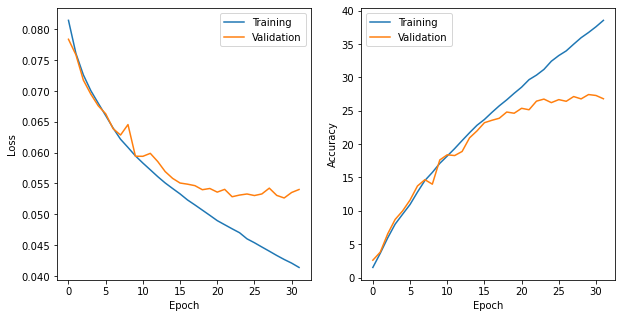

In [30]:
'绘图'
plot(loss_tr_hist, loss_val_hist, accuracy_tr_hist, accuracy_val_hist)


In [ ]:
'获取GPU信息'
if torch.cuda.is_available():
    GPU_nums = torch.cuda.device_count()
    print('got {} GPUs'.format(GPU_nums))
    for i_gpu in range(GPU_nums):
        print('GPU{}:{}'.format(i_gpu, torch.cuda.get_device_name(i_gpu)))


In [37]:
# model = CNN()
model = torch.load('31_13_28_v2.pkl')
# model = ResNet()
# model = load_model(model_filename, model, mode = 'test')
if gpu:
    model.cuda()
pred, loss_test, accuracy_test = test(model, dataloader_test)
print('Test Loss: {0:7.4f}  |  Test Accuracy: {1:7.4f}'.format(loss_test, accuracy_test))

test: 10.0kB [00:04, 2.20kB/s]                                                                      

Test Loss:  0.0503  |  Test Accuracy: 45.7000
